In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from ml_metrics import rmsle
from sklearn.cross_validation import LabelKFold
from sklearn.grid_search import ParameterGrid

import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv', parse_dates=['datetime'])
test = pd.read_csv('test.csv', parse_dates=['datetime'])

df_all = train.append(test)

df_all['count_log'] = np.log( df_all['count'] + 1 )
df_all['casual_log'] = np.log( df_all['casual'] + 1 )
df_all['registered_log'] = np.log( df_all['registered'] + 1 )

df_all['is_test'] = df_all['count'].isnull()

In [3]:
def select_features(data):
    black_list = ['casual', 'registered', 'count', 'is_test', 'datetime', 'count_log', 'casual_log', 'registered_log']
    return [feat for feat in data.columns if feat not in black_list]
    
def get_X_y(data, target_var='count'):
    features = select_features(data)
    return data[features].values, data[target_var].values

In [4]:
def cat_hour(hour):
    if 5 >= hour < 10:
        return 1#morning
    elif 10 >= hour < 17:
        return 2#day
    elif 17 >= hour < 23:
        return 3 #evening
    else:
        return 4 #night
    
def feature_engineering(data):
    data['year'] = data['datetime'].dt.year
    data['diff_year'] = data['year'] - 2010
    data['month'] = data['datetime'].dt.month
    data['day'] = data['datetime'].dt.day
    data['hour'] = data['datetime'].dt.hour
    data['minute'] = data['datetime'].dt.minute
    data['dayofweek'] = data['datetime'].dt.dayofweek
    data['weekofyear'] = data['datetime'].dt.weekofyear
    data['weekend'] = data.dayofweek.map(lambda x: int(x in [5,6]) )
    data['time_of_day'] = data['hour'].map(cat_hour)
    
    data['dayofyear'] = data['datetime'].dt.dayofyear
    data['day_'] = data[ ['year', 'dayofyear'] ].apply(lambda x: x['dayofyear'] + int(str(x['year'])[-1]) * 365  , axis=1)
    
    data['rush_hour'] = data['datetime'].apply(lambda i: min([np.fabs(9-i.hour), np.fabs(20-i.hour)]))
    data.loc[:,('rush_hour')] = data['datetime'].apply(lambda i: np.fabs(14-i.hour))
    data[data['workingday'] != 0]['rush_hour'] = 0
    
    data['holiday'] = data[['month', 'day', 'holiday', 'year']].apply(lambda x: (x['holiday'], 1)[x['year'] == 2012 and x['month'] == 10 and (x['day'] in [30])], axis = 1)

    #christmas day and others
    data['holiday'] = data[['month', 'day', 'holiday']].apply(lambda x: (x['holiday'], 1)[x['month'] == 12 and (x['day'] in [24, 26, 31])], axis = 1)
    data['workingday'] = data[['month', 'day', 'workingday']].apply(lambda x: (x['workingday'], 0)[x['month'] == 12 and x['day'] in [24, 31]], axis = 1)
    
    data['peak'] = data[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18 or 12 <= x['hour'] <= 12)) or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)
    
    
    data['sticky'] = data[['humidity', 'workingday']].apply(lambda x: (0, 1)[x['workingday'] == 1 and x['humidity'] >= 60], axis = 1)
    

    if not 'count_season' in data:
        by_season = data[False == data.is_test].groupby('season')[['count_log']].agg(sum)
        by_season.columns = ['count_season']
        data = data.join(by_season, on='season')
    
    return data

df_all = feature_engineering(df_all)

/Users/vova/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [676]:
# # def train_test_split(data, cutoff_day = 15):
# #     df_train = data[ data.datetime.dt.day <= cutoff_day]
# #     df_test = data[ data.datetime.dt.day > cutoff_day]

# #     return df_train, df_test

# # def get_train_test_X_y(train, target_var='count'):
# #     df_train, df_test = train_test_split(train)
# #     X_train, y_train = get_X_y(df_train, target_var)
# #     X_test, y_test = get_X_y(df_test, target_var)

# #     return X_train, y_train, X_test, y_test

# def score(y_test, y_pred):
#     y_pred[ y_pred < 0] = 0
#     return rmsle(y_test, y_pred)

# def evaluate_model_count(model, train):
#     X_train, y_train, X_test, y_test = get_train_test_X_y(train, 'count')
#     model.fit(X_train, y_train)
    
#     return score(y_test, model.predict(X_test))


# def _evaluate_model_count_log(model, data):
#     df_train, df_test = train_test_split(data)
#     feats = select_features(data)
    
#     X_train, X_test = df_train[feats], df_test[feats]
#     y_train, y_test = df_train['count_log'], df_test['count']
    
#     model.fit(X_train, y_train)
#     y_pred_log = model.predict(X_test)
#     y_pred = np.exp( y_pred_log ) - 1
#     return y_test, y_pred
    
# def evaluate_model_count_log(model, data):
#     y_test, y_pred = _evaluate_model_count_log(model, data)
#     return score(y_test, y_pred)


# def _evaluate_model_reg_cas_log(model, data):
#     df_train, df_test = train_test_split(data)
#     feats = select_features(data)
    
#     X_train, X_test = df_train[feats], df_test[feats]
#     y_reg_train = df_train['registered_log']
#     y_cas_train = df_train['casual_log']
#     y_test = df_test['count']
    
#     model.fit(X_train, y_reg_train)
#     y_pred_reg_log = model.predict(X_test)
#     y_pred_reg = np.exp( y_pred_reg_log ) - 1
    
#     model.fit(X_train, y_cas_train)
#     y_pred_cas_log = model.predict(X_test)
#     y_pred_cas = np.exp( y_pred_cas_log ) - 1
    
#     return y_test, y_pred_reg, y_pred_cas
    

# def evaluate_model_reg_cas_log(model, data):
#     y_test, y_pred_reg, y_pred_cas = _evaluate_model_reg_cas_log(model, data)
#     y_pred = y_pred_reg + y_pred_cas
    
#     return score(y_test, y_pred)


# def evaluate_model_count_reg_cas_log(model, data):
#     y_test, y_pred_count = _evaluate_model_count_log(model, data)
#     _, y_pred_reg, y_pred_cas = _evaluate_model_reg_cas_log(model, data)
    
#     y_pred = .5*y_pred_count + .5*(y_pred_reg + y_pred_cas)
    
#     return score(y_test, y_pred)

In [677]:
# df_t = df_all[~df_all.is_test]

# gbm_params = {'n_estimators': 150, 'max_depth': 5, 'random_state': 0, 'min_samples_leaf' : 10, 'learning_rate': 0.1, 'subsample': 0.7, 'loss': 'ls'}
# model = GradientBoostingRegressor(**gbm_params)

# model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, subsample=0.7, colsample_bytree=0.7)



# print evaluate_model_count(model, df_t)
# print evaluate_model_count_log(model, df_t)
# print evaluate_model_reg_cas_log(model, df_t)
# print evaluate_model_count_reg_cas_log(model, df_t)

## Modeling

In [6]:
def modeling(models, data):    
    labels = data['month'].values
    #feats = select_features(data)
    
    scores = []
    for n_fold, (train_idx, test_idx) in enumerate(LabelKFold(labels, n_folds=3)):
        print("n_fold: ", n_fold)
        for weight_model, feats, model in models:
            X = data[feats].values
            
            X_train, X_test = X[train_idx], X[test_idx]
            y_reg_train = data['registered_log'][train_idx].astype('float')
            y_cas_train = data['casual_log'][train_idx].astype('float')
            y_test = data['count'][test_idx].astype('float')

            y_pred = np.array([0.] * len(y_test))
        
            model.fit(X_train, y_reg_train)
            y_pred_reg_log = model.predict(X_test)
            y_pred_reg = np.exp( y_pred_reg_log ) - 1

            model.fit(X_train, y_cas_train)
            y_pred_cas_log = model.predict(X_test)
            y_pred_cas = np.exp( y_pred_cas_log ) - 1

            y_pred += weight_model * (y_pred_reg + y_pred_cas)
            
        score = rmsle(y_test, y_pred)
        scores.append(score)
        
    print np.mean(scores), np.std(scores), scores
        

#0.36234  vs 0.332       
xgb_params = {'n_estimators':150,  'learning_rate':0.1, 'max_depth':5, 'subsample':0.6, 'colsample_bytree': 0.8}
xgb_model = xgb.XGBRegressor(**xgb_params)

#0.36267 vs 0.333
#gbm_params = {'n_estimators': 150, 'max_depth': 5, 'random_state': 2, 'min_samples_leaf' : 15, 'learning_rate': 0.1, 'subsample': 0.8, 'loss': 'huber'}
gbm_params = {'n_estimators': 150, 'max_depth': 5, 'random_state': 0, 'min_samples_leaf' : 10, 'learning_rate': 0.1, 'subsample': 0.7, 'loss': 'ls'}
gbm_model = GradientBoostingRegressor(**gbm_params)

#1000 => 0.443; 100 => 0.445
#       0.44606
#rf_params = {'n_estimators': 1000, 'max_depth': 15, 'random_state': 0, 'min_samples_split' : 5, 'n_jobs': -1}
rf_params = {'n_estimators': 1000, 'max_depth': 15, 'random_state': 0, 'min_samples_split' : 5, 'n_jobs': -1}
rf_model = RandomForestRegressor(**rf_params)

#kaggle 0.43164 vs 0.433
et_params = {'n_estimators': 300, 'min_samples_leaf': 5, 'random_state': 0, 'min_samples_split': 2}
et_model = ExtraTreesRegressor(**et_params)

bag_params = {'n_estimators': 100, 'max_samples': .8, 'max_features': .8, 'random_state': 0, 'n_jobs': -1}
bag_model = BaggingRegressor(**bag_params)

feats_one = ['weather', 'temp', 'atemp', 'humidity', 'windspeed', 'holiday', 'workingday', 'season','hour', 'dayofweek', 'year']
feats_two = ['weather', 'temp', 'atemp', 'windspeed', 'workingday', 'season', 'hour', 'dayofweek', 'weekofyear']

gbm_cols = [
    'weather', 'temp', 'atemp', 'humidity', 'windspeed',
    'holiday', 'workingday', 'season',
    'hour', 'dayofweek', 'year'
]

rf_cols = [
    'weather', 'temp', 'atemp', 'windspeed',
    'workingday', 'season', 'holiday', 'sticky',
    'hour', 'dayofweek', 'weekofyear', 'peak'
    ]


models = [
   #(1., feats_two, bag_model)
   #(1., feats_two, et_model),
   (.2, rf_cols, rf_model),
   #(.8, feats_one, xgb_model),
   #(.1, feats_two, xgb_model),
   (.8, gbm_cols, gbm_model)
]

modeling(models, df_all[~df_all.is_test])

('n_fold: ', 0)
('n_fold: ', 1)
('n_fold: ', 2)
0.40171114054 0.0141173038414 [0.4208501707225773, 0.38722018822134413, 0.3970630626767932]


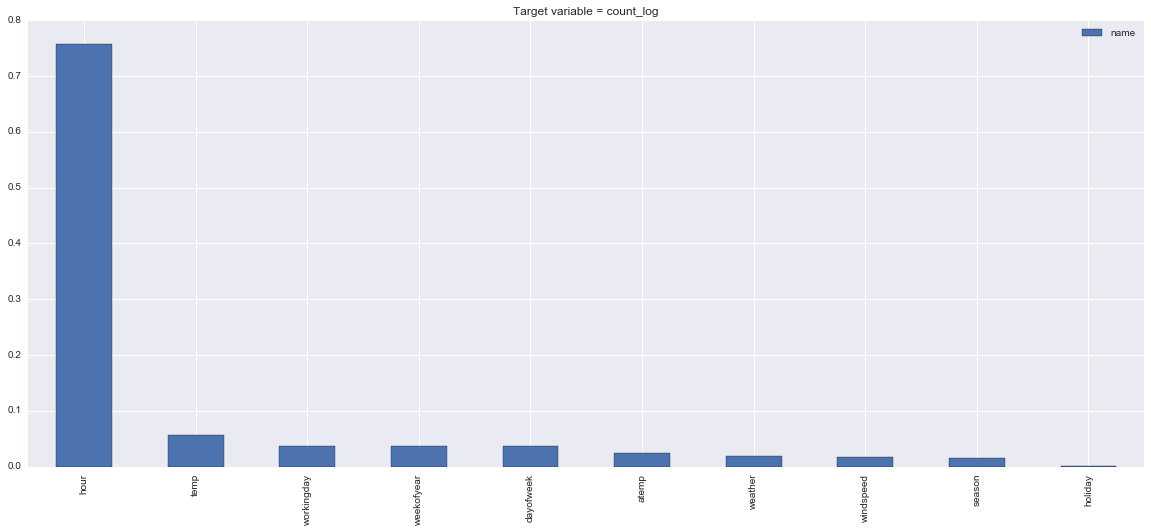

In [8]:
def get_importance_features(data, model, limit, target_variable):
    X,y = get_X_y(data, target_variable)
    cols = select_features(data)
    
    model.fit(X, y)
    feats = pd.DataFrame(model.feature_importances_, index=data[cols].columns)
    feats = feats.sort_values(by=[0], ascending=False) [:limit]
    return feats.rename(columns={0:'name'})
    
def draw_importance_features(data, model=RandomForestRegressor(), limit=30, target_variable='count'):
    feats = get_importance_features(data, model, limit, target_variable)
    feats.plot(kind='bar', figsize=(20, 8), title="Target variable = {0}".format(target_variable))
    
df_t = df_all[~df_all.is_test]
df_ts = df_t[ ['count_log', 'weather', 'temp', 'atemp', 'windspeed', 'workingday', 'season', 'holiday', 'hour', 'dayofweek', 'weekofyear'] ]    
draw_importance_features(df_ts, target_variable='count_log')

In [682]:
def tuning_models():
    rf_params = {
        'n_estimators': [100, 150, 200], 
        'min_samples_split': [5, 15, 25], 
        'n_jobs': [-1],
        'min_samples_leaf': [1, 2, 3]
    }

    bagging_params = {
        'n_estimators': [100, 150, 170, 180, 200],
        'n_jobs': [-1],
    }

    extratree_params = {
        'n_estimators': [50, 100, 150],
        'min_samples_leaf': [1, 2],
        'min_samples_split': [2, 5, 7, 9],
        'n_jobs': [-1],
    }

    yield (extratree_params, 'extra_tree', ExtraTreesRegressor)
    yield (rf_params, 'random_forest', RandomForestRegressor)
    yield (bagging_params, 'bagging', BaggingRegressor)

In [683]:
X_train, y_train_reg, X_test, y_test_reg = get_train_test_X_y(df_all[ False == df_all.is_test ], 'registered_log')
_, y_train_reg, _, y_test_reg = get_train_test_X_y(df_all[ False == df_all.is_test ], 'casual_log')

scores = []

for params_model, name, model_class in tuning_models():
    print name
    for params in ParameterGrid(params_model):
        pass
        #...
        
print('TOP 5')
print( sorted(scores, key=lambda x: x[1])[:5] )

extra_tree
random_forest
bagging
TOP 5
[]


##  Submit

In [9]:
feats = ['weather', 'temp', 'atemp', 'humidity', 'windspeed', 'holiday', 'workingday', 'season','hour', 'dayofweek', 'year']
xgb_features = feats
gbm_features = feats
rf_features = [
    'weather', 'temp', 'atemp', 'windspeed',
    'workingday', 'season', 'holiday',
    'hour', 'dayofweek', 'weekofyear', 'rush_hour', 'peak'
    ]

df_train = df_all[False == df_all['count'].isnull()]
df_test =  df_all[ df_all['count'].isnull()]                 


_, y_train_count = get_X_y(df_train, 'count_log')
_, y_train_reg = get_X_y(df_train, 'registered_log')
_, y_train_cas = get_X_y(df_train, 'casual_log')

gbm_X_train = df_train[gbm_features]
xgb_X_train = df_train[xgb_features]
rf_X_train = df_train[rf_features]
et_X_train = df_train[rf_features]


gbm_X_test  = df_test[gbm_features]
xgb_X_test = df_test[xgb_features]
rf_X_test  = df_test[rf_features]
et_X_test  = df_test[rf_features]

et_params = {'min_samples_split': 2, 'n_estimators': 50, 'n_jobs': -1, 'min_samples_leaf': 2}

gbm_params = {'n_estimators': 150, 'max_depth': 5, 'random_state': 0, 'min_samples_leaf' : 10, 'learning_rate': 0.1, 'subsample': 0.7, 'loss': 'ls'}
rf_params = {'n_estimators': 1000, 'max_depth': 15, 'random_state': 0, 'min_samples_split' : 5, 'n_jobs': -1}
xgb_params = {'n_estimators':150,  'learning_rate':0.1, 'max_depth':5, 'subsample':0.6, 'colsample_bytree': 0.8}
et_params = {'n_estimators': 100, 'min_samples_leaf': 5, 'random_state': 0, 'min_samples_split': 2}


def predict(X_train, X_test, model):
    model.fit(X_train, y_train_count)
    y_pred_count_log = model.predict(X_test)
    y_pred_count = np.exp( y_pred_count_log ) - 1
    
    model.fit(X_train, y_train_reg)
    y_pred_reg_log = model.predict(X_test)
    y_pred_reg = np.exp( y_pred_reg_log ) - 1

    model.fit(X_train, y_train_cas)
    y_pred_cas_log = model.predict(X_test)
    y_pred_cas = np.exp( y_pred_cas_log ) - 1
    
    return y_pred_reg + y_pred_cas
    #return .3*y_pred_count + .7*(y_pred_reg + y_pred_cas)

gbm_count = predict(gbm_X_train, gbm_X_test, GradientBoostingRegressor(**gbm_params))
rf_count = predict(rf_X_train, rf_X_test, RandomForestRegressor(**rf_params))
xgb_count = predict(xgb_X_train, xgb_X_test, xgb.XGBRegressor(**xgb_params))
#et_count = predict(et_X_train, et_X_test, ExtraTreesRegressor(**et_params))

#count =  .5*xgb_count + .5*gbm_count 
count = .2*rf_count + .8*( .3*gbm_count  + .7*xgb_count)
#count = .2*et_count + .4*xgb_count + .4*gbm_count 

test['count'] = count

In [10]:
test[ ['datetime', 'count'] ].to_csv('final_submit.csv', index=False)